In [20]:
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# Load dataset from JSON file
with open("/content/drive/MyDrive/Colab Notebooks/Kilter/training_data_extended.json", "r") as f:
    data = json.load(f)

# Extract features and labels
frames = [item["frame"] for item in data]
angles = [item["angle"] for item in data]
holds = [len(item["frame"]) / 10 for item in data]
grade = [item["grade"] for item in data]

# Tokenize the frame strings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(frames)
frame_sequences = tokenizer.texts_to_sequences(frames)
frame_sequences = pad_sequences(frame_sequences, padding='post')

#Train model as a regresor

In [35]:
# Convert features to NumPy arrays
angles = np.array(angles).reshape(-1, 1).astype(np.float32)
holds = np.array(holds).reshape(-1, 1).astype(np.float32)
grade = np.array(grade).reshape(-1, 1).astype(np.float32)

# Split into training and test sets
X_frames_train, X_frames_test, X_angles_train, X_angles_test, X_holds_train, X_holds_test, y_train, y_test = train_test_split(
    frame_sequences, angles, holds, grade, test_size=0.2, random_state=42
)

# Model inputs
frame_input = Input(shape=(frame_sequences.shape[1],), name="frame_input")
angle_input = Input(shape=(1,), name="angle_input")
holds_input = Input(shape=(1,), name="holds_input")

# Frame embedding
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 16
x1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(frame_input)
x1 = Flatten()(x1)

# Fully connected layers
x = Concatenate()([x1, angle_input, holds_input])
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(1)(x)

# Build and compile the model
model = Model(inputs=[frame_input, angle_input, holds_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(
    [X_frames_train, X_angles_train, X_holds_train],
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_frames_test, X_angles_test, X_holds_test], y_test)
)

# Save the model
model.save("difficulty_model.h5")

Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 58.0451 - mae: 5.6892 - val_loss: 24.0389 - val_mae: 3.9493
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 14.6868 - mae: 2.9527 - val_loss: 11.3046 - val_mae: 2.5364
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.9017 - mae: 1.5059 - val_loss: 9.7287 - val_mae: 2.2508
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6615 - mae: 0.9881 - val_loss: 8.8755 - val_mae: 2.1156
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2766 - mae: 0.8749 - val_loss: 8.8875 - val_mae: 2.0970
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.0962 - mae: 0.8259 - val_loss: 8.5395 - val_mae: 2.0760
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0494 - mae: 0.8085 - val_loss: 8.3925 - val_mae: 2.0178
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0199 - mae: 0.7940 - val_loss: 8.2161 - val_mae: 2.0102
Epoch 9/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step 

In [56]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    # Normalize grade between 0 and 1 based on known range (10 to 30)
    #weights = (y_true - 10) / (30 - 10) + 1  # Weights from 1.0 (grade 10) to 2.0 (grade 30)
    weights = K.pow((y_true - 10) / 20 + 1, 4)
    return K.mean(weights * K.square(y_true - y_pred), axis=-1)

model.compile(optimizer='adam', loss=weighted_mse, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

# Train the model
model.fit(
    [X_frames_train, X_angles_train, X_holds_train],
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_frames_test, X_angles_test, X_holds_test], y_test),
    callbacks=[early_stop]
)

# Save the model
model.save('my_model.keras')

Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.5962 - mae: 0.2443 - val_loss: 38.3023 - val_mae: 1.8750
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4469 - mae: 0.2192 - val_loss: 37.1376 - val_mae: 1.8852
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5337 - mae: 0.2393 - val_loss: 38.7190 - val_mae: 1.8790
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4576 - mae: 0.2221 - val_loss: 38.2750 - val_mae: 1.8666
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4476 - mae: 0.2169 - val_loss: 37.5957 - val_mae: 1.8772
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4933 - mae: 0.2285 - val_loss: 37.6617 - val_mae: 1.8743
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5053 - mae: 0.2325 - val_loss: 38.6310 - val_mae: 1.8769
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4360 - mae: 0.2118 - val_loss: 37.5499 - val_mae: 1.8728
Epoch 9/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/

In [58]:
results_df['grade_range'] = pd.cut(results_df['actual_grade'], bins=[10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30])
results_df.groupby('grade_range')['deviation'].mean()

<ipython-input-58-935539580>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_df.groupby('grade_range')['deviation'].mean()


,deviation
grade_range,
"(10.0, 12.5]",2.717822
"(12.5, 15.0]",2.226047
"(15.0, 17.5]",1.930531
"(17.5, 20.0]",1.445117
"(20.0, 22.5]",1.202052
"(22.5, 25.0]",1.639850
"(25.0, 27.5]",2.628466
"(27.5, 30.0]",3.419742


#Charts for regressor

In [ ]:
# Evaluate the model
loss, mae = model.evaluate([X_frames_test, X_angles_test, X_holds_test], y_test, verbose=0)
print(f"Mean Absolute Error on test set: {mae:.4f}")

# Get predictions
y_pred = model.predict([X_frames_test, X_angles_test, X_holds_test])

# Create DataFrame with test data and predictions
results_df = pd.DataFrame({
    'angle': X_angles_test.flatten(),
    'holds': X_holds_test.flatten(),
    'actual_grade': y_test.flatten(),
    'predicted_grade': y_pred.flatten()
})

# Calculate deviation (absolute error)
results_df['deviation'] = np.abs(results_df['predicted_grade'] - results_df['actual_grade'])

# Create bins for angles and grades
angle_bins = np.linspace(results_df['angle'].min(), results_df['angle'].max(), 10)
grade_bins = np.linspace(results_df['actual_grade'].min(), results_df['actual_grade'].max(), 10)

# Bin the data
results_df['angle_bin'] = pd.cut(results_df['angle'], bins=angle_bins)
results_df['grade_bin'] = pd.cut(results_df['actual_grade'], bins=grade_bins)

# Pivot table for heatmap
heatmap_data = results_df.groupby(['angle_bin', 'grade_bin'])['deviation'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Deviation'},
    linewidths=.5
)
plt.title('Model Deviation Heatmap (Angle vs Grade)')
plt.xlabel('Grade Bins')
plt.ylabel('Angle Bins')
plt.tight_layout()
plt.show()

# Boxplot: Deviation by Grade
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=results_df['grade_bin'],
    y=results_df['deviation'],
    palette='YlOrRd'
)
plt.title('Deviation Distribution by Grade')
plt.xlabel('Grade Bins')
plt.ylabel('Deviation (Absolute Error)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar plot: Average Deviation by Grade Bin
grade_dev = results_df.groupby('grade_bin')['deviation'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(
    x=grade_dev['grade_bin'].astype(str),
    height=grade_dev['deviation'],
    color='salmon',
    edgecolor='darkred'
)
plt.title('Average Deviation by Grade Range', fontsize=14)
plt.xlabel('Grade Range', fontsize=12)
plt.ylabel('Average Deviation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#Train model only with 45 degree board

In [62]:
import numpy as np

# Convert angles to numpy array if not already
angles = np.array(angles).reshape(-1, 1).astype(np.float32)
holds = np.array(holds).reshape(-1, 1).astype(np.float32)
grade = np.array(grade).reshape(-1, 1).astype(np.float32)

# Convert frame_sequences if not already a NumPy array
frame_sequences = np.array(frame_sequences)

# Filter indices where angle == 45
mask = (angles.flatten() == 45)

# Apply the mask
frame_sequences = frame_sequences[mask]
angles = angles[mask]
holds = holds[mask]
grade = grade[mask]

# Proceed with train/test split
from sklearn.model_selection import train_test_split

X_frames_train, X_frames_test, X_angles_train, X_angles_test, X_holds_train, X_holds_test, y_train, y_test = train_test_split(
    frame_sequences, angles, holds, grade, test_size=0.2, random_state=42
)

In [63]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    # Normalize grade between 0 and 1 based on known range (10 to 30)
    #weights = (y_true - 10) / (30 - 10) + 1  # Weights from 1.0 (grade 10) to 2.0 (grade 30)
    weights = K.pow((y_true - 10) / 20 + 1, 4)
    return K.mean(weights * K.square(y_true - y_pred), axis=-1)

model.compile(optimizer='adam', loss=weighted_mse, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

# Train the model
model.fit(
    [X_frames_train, X_angles_train, X_holds_train],
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_frames_test, X_angles_test, X_holds_test], y_test),
    callbacks=[early_stop]
)

# Save the model
model.save('my_model.keras')

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9.2114 - mae: 0.6838 - val_loss: 8.8017 - val_mae: 0.6110
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.0880 - mae: 0.6897 - val_loss: 8.1972 - val_mae: 0.6206
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.2347 - mae: 0.5802 - val_loss: 8.1945 - val_mae: 0.6636
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.8456 - mae: 0.5747 - val_loss: 8.3721 - val_mae: 0.6684
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.7190 - mae: 0.4925 - val_loss: 8.9052 - val_mae: 0.8129
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.4117 - mae: 0.5008 - val_loss: 9.0029 - val_mae: 0.7315


In [64]:
results_df['grade_range'] = pd.cut(results_df['actual_grade'], bins=[10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30])
results_df.groupby('grade_range')['deviation'].mean()

<ipython-input-64-935539580>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_df.groupby('grade_range')['deviation'].mean()


,deviation
grade_range,
"(10.0, 12.5]",1.593293
"(12.5, 15.0]",0.699626
"(15.0, 17.5]",0.478973
"(17.5, 20.0]",0.586653
"(20.0, 22.5]",0.323587
"(22.5, 25.0]",0.315399
"(25.0, 27.5]",0.873524
"(27.5, 30.0]",0.731826


#Charts for regressor 45 degrees

Mean Absolute Error on test set: 0.6110
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<ipython-input-66-2496587137>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


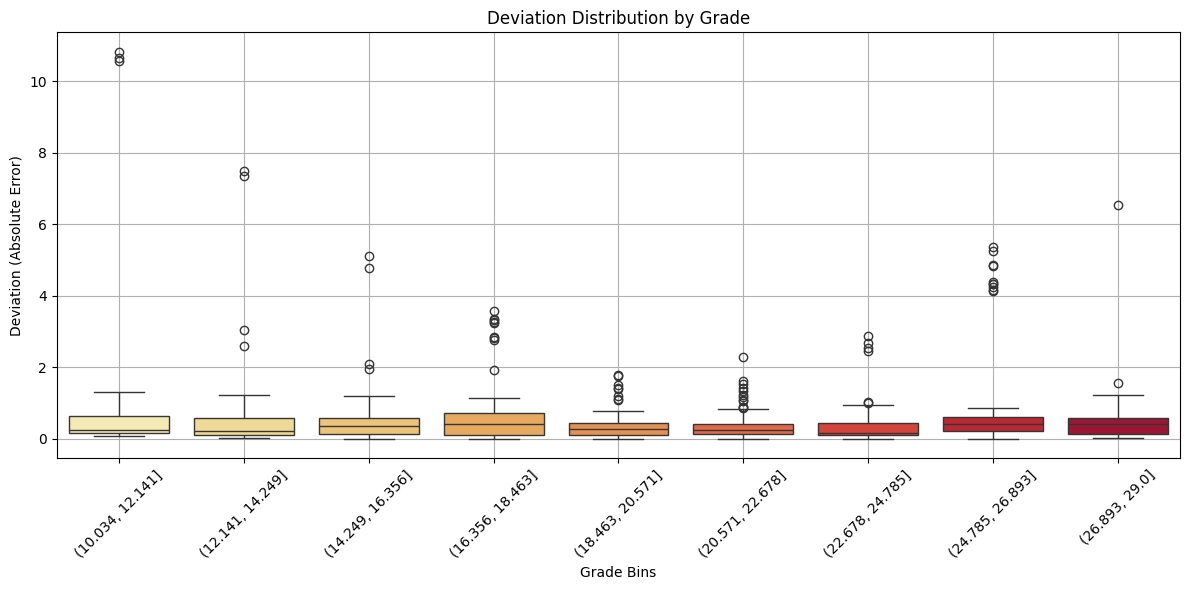

<ipython-input-66-2496587137>:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grade_dev = results_df.groupby('grade_bin')['deviation'].mean().reset_index()


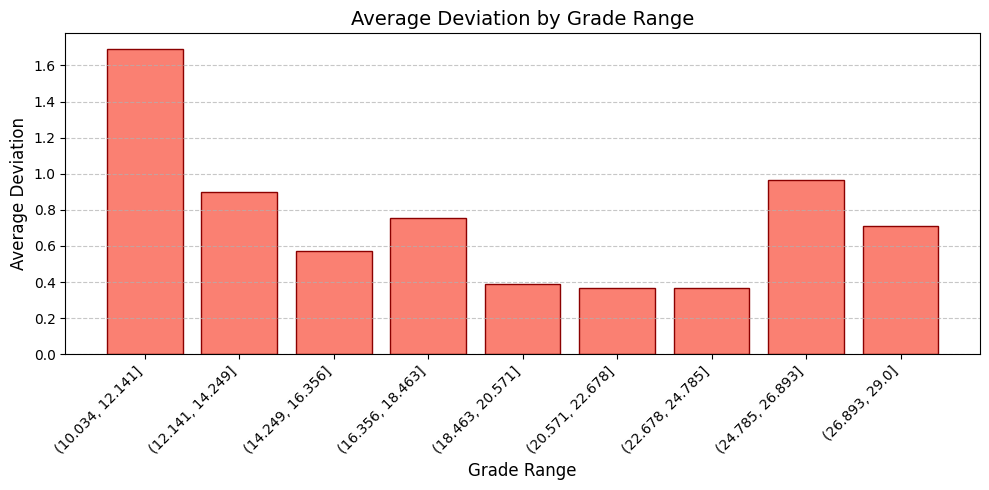

In [66]:
# Evaluate the model
loss, mae = model.evaluate([X_frames_test, X_angles_test, X_holds_test], y_test, verbose=0)
print(f"Mean Absolute Error on test set: {mae:.4f}")

# Get predictions
y_pred = model.predict([X_frames_test, X_angles_test, X_holds_test])

# Create DataFrame with test data and predictions
results_df = pd.DataFrame({
    'holds': X_holds_test.flatten(),
    'actual_grade': y_test.flatten(),
    'predicted_grade': y_pred.flatten()
})

# Calculate deviation (absolute error)
results_df['deviation'] = np.abs(results_df['predicted_grade'] - results_df['actual_grade'])

# Create bins for grades only
grade_bins = np.linspace(results_df['actual_grade'].min(), results_df['actual_grade'].max(), 10)
results_df['grade_bin'] = pd.cut(results_df['actual_grade'], bins=grade_bins)

# Boxplot: Deviation by Grade
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=results_df['grade_bin'],
    y=results_df['deviation'],
    palette='YlOrRd'
)
plt.title('Deviation Distribution by Grade')
plt.xlabel('Grade Bins')
plt.ylabel('Deviation (Absolute Error)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar plot: Average Deviation by Grade Bin
grade_dev = results_df.groupby('grade_bin')['deviation'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(
    x=grade_dev['grade_bin'].astype(str),
    height=grade_dev['deviation'],
    color='salmon',
    edgecolor='darkred'
)
plt.title('Average Deviation by Grade Range', fontsize=14)
plt.xlabel('Grade Range', fontsize=12)
plt.ylabel('Average Deviation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#Train model as a classificator

In [ ]:
# Model inputs
frame_input = Input(shape=(frame_sequences.shape[1],), name="frame_input")
angle_input = Input(shape=(1,), name="angle_input")
holds_input = Input(shape=(1,), name="holds_input")

# Frame embedding
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 16
x1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(frame_input)
x1 = Flatten()(x1)

# Fully connected layers
x = Concatenate()([x1, angle_input, holds_input])
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(1)(x)

# Build and compile the model
model = Model(inputs=[frame_input, angle_input, holds_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(
    [X_frames_train, X_angles_train, X_holds_train],
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_frames_test, X_angles_test, X_holds_test], y_test)
)

# Save the model
model.save("difficulty_model.h5")

In [32]:
# Convert other features to numpy arrays
angles = np.array(angles).reshape(-1, 1).astype(np.float32)
holds = np.array(holds).reshape(-1, 1).astype(np.float32)

# Convert float grades to 20 bins (classes)
min_grade, max_grade = 10, 30
num_classes = 20
grade_class_indices = np.clip(((np.array(grade) - min_grade) / (max_grade - min_grade) * num_classes).astype(int), 0, num_classes - 1)
grade_onehot = to_categorical(grade_class_indices, num_classes=num_classes)

# Split into training and test sets
X_frames_train, X_frames_test, X_angles_train, X_angles_test, X_holds_train, X_holds_test, y_train, y_test = train_test_split(
    frame_sequences, angles, holds, grade_onehot, test_size=0.2, random_state=42
)

# Input layers
frame_input = Input(shape=(frame_sequences.shape[1],), name="frame_input")
angle_input = Input(shape=(1,), name="angle_input")
holds_input = Input(shape=(1,), name="holds_input")

# Frame embedding
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 16
x1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(frame_input)
x1 = Flatten()(x1)

# Combine all features
x = Concatenate()([x1, angle_input, holds_input])
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
output = Dense(num_classes, activation='softmax')(x)

# Build and compile the model
model = Model(inputs=[frame_input, angle_input, holds_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model.fit(
    [X_frames_train, X_angles_train, X_holds_train],
    y_train,
    epochs=30,
    batch_size=32,
    validation_data=([X_frames_test, X_angles_test, X_holds_test], y_test),
    callbacks=[early_stop]
)

# Save the model
model.save("difficulty_classifier_model.h5")

Epoch 1/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.0714 - loss: 3.8264 - val_accuracy: 0.0862 - val_loss: 2.9263
Epoch 2/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1035 - loss: 2.9254 - val_accuracy: 0.1186 - val_loss: 2.8398
Epoch 3/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1143 - loss: 2.8298 - val_accuracy: 0.1280 - val_loss: 2.7872
Epoch 4/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1388 - loss: 2.7014 - val_accuracy: 0.1596 - val_loss: 2.5911
Epoch 5/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2013 - loss: 2.3630 - val_accuracy: 0.2012 - val_loss: 2.5391
Epoch 6/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2438 - loss: 2.1617 - val_accuracy: 0.2158 - val_loss: 2.5955
Epoch 7/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2702 - loss: 2.0421 - val_accuracy: 0.2056 - val_loss: 2.6767
Epoch 8/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2893 - loss: 1.9550 - val_accuracy: 0

In [33]:
import numpy as np

# Predict class probabilities on test set
y_pred_probs = model.predict([X_frames_test, X_angles_test, X_holds_test])

# Convert one-hot true labels and predicted probabilities to class indices
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calculate grade difference (in class bins)
grade_distance = np.abs(y_true_classes - y_pred_classes)

# Print evaluation metrics
print(f"Mean Grade Distance: {np.mean(grade_distance):.2f}")
print(f"Median Grade Distance: {np.median(grade_distance):.2f}")
print(f"Percent within 1 grade: {(grade_distance <= 1).mean() * 100:.2f}%")
print(f"Percent within 2 grades: {(grade_distance <= 2).mean() * 100:.2f}%")
print(f"Percent within 3 grades: {(grade_distance <= 3).mean() * 100:.2f}%")

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Grade Distance: 2.30
Median Grade Distance: 2.00
Percent within 1 grade: 43.27%
Percent within 2 grades: 63.34%
Percent within 3 grades: 77.04%


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<ipython-input-34-205582611>:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = results_df.groupby(['angle_bin', 'grade_bin'])['deviation'].mean().unstack()


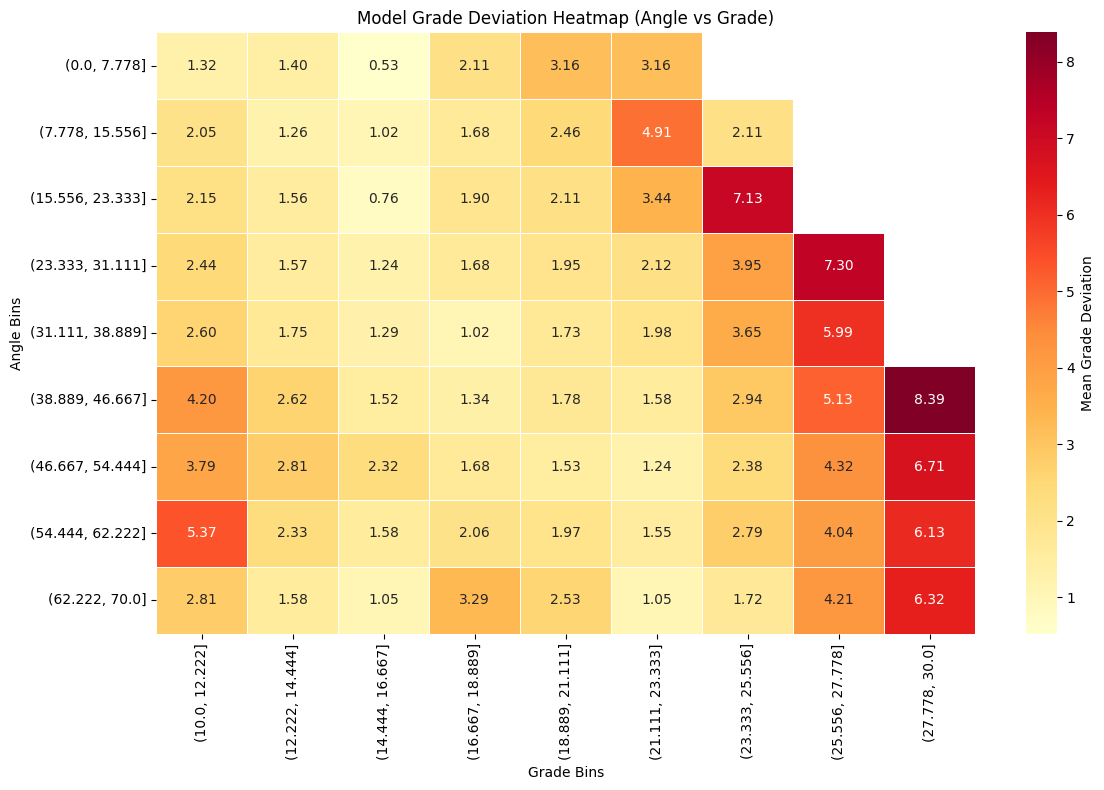

<ipython-input-34-205582611>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


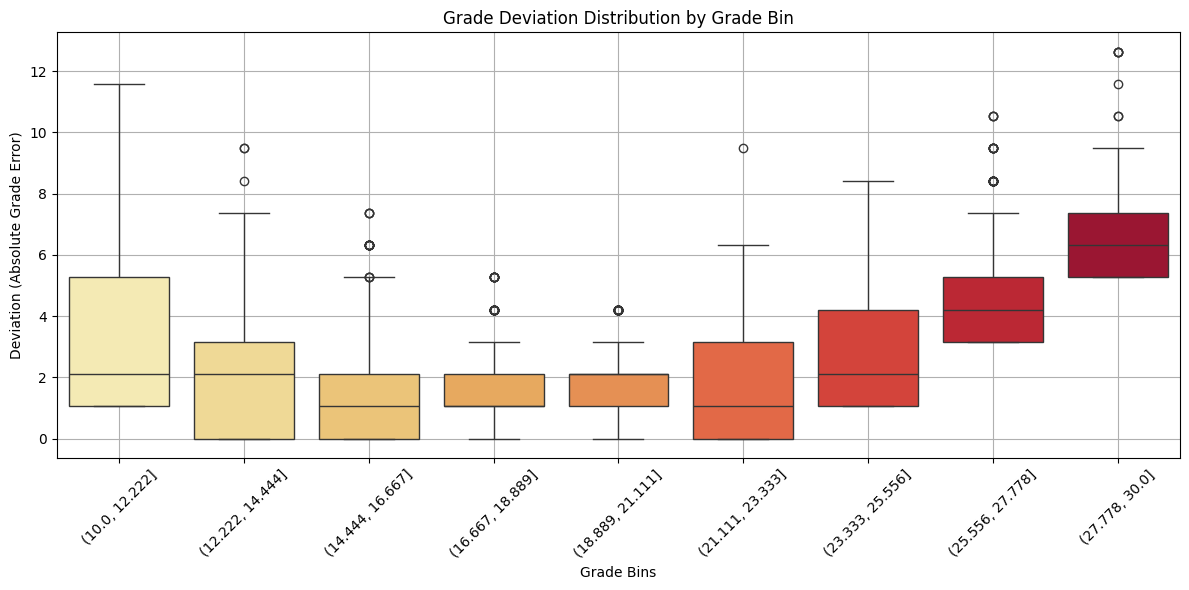

<ipython-input-34-205582611>:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grade_dev = results_df.groupby('grade_bin')['deviation'].mean().reset_index()


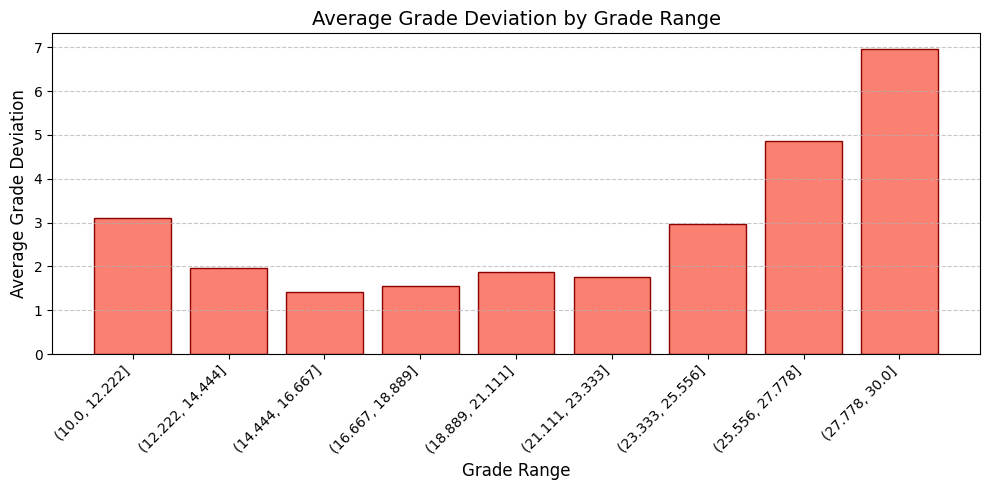

In [34]:
# Predict class probabilities and convert to grade classes
y_pred_probs = model.predict([X_frames_test, X_angles_test, X_holds_test])
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Map class indices back to actual grades
grade_range = np.linspace(10, 30, 20)  # 20 classes from 10 to 30
y_pred_grades = grade_range[y_pred_classes]
y_true_grades = grade_range[y_true_classes]

# Create DataFrame with test data and predictions
results_df = pd.DataFrame({
    'angle': X_angles_test.flatten(),
    'holds': X_holds_test.flatten(),
    'actual_grade': y_true_grades,
    'predicted_grade': y_pred_grades
})

# Calculate deviation (grade distance)
results_df['deviation'] = np.abs(results_df['predicted_grade'] - results_df['actual_grade'])

# Create bins for angles and grades
angle_bins = np.linspace(results_df['angle'].min(), results_df['angle'].max(), 10)
grade_bins = np.linspace(results_df['actual_grade'].min(), results_df['actual_grade'].max(), 10)

# Bin the data
results_df['angle_bin'] = pd.cut(results_df['angle'], bins=angle_bins)
results_df['grade_bin'] = pd.cut(results_df['actual_grade'], bins=grade_bins)

# Pivot table for heatmap
heatmap_data = results_df.groupby(['angle_bin', 'grade_bin'])['deviation'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Grade Deviation'},
    linewidths=.5
)
plt.title('Model Grade Deviation Heatmap (Angle vs Grade)')
plt.xlabel('Grade Bins')
plt.ylabel('Angle Bins')
plt.tight_layout()
plt.show()

# Boxplot: Deviation by Grade
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=results_df['grade_bin'],
    y=results_df['deviation'],
    palette='YlOrRd'
)
plt.title('Grade Deviation Distribution by Grade Bin')
plt.xlabel('Grade Bins')
plt.ylabel('Deviation (Absolute Grade Error)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar plot: Average Deviation by Grade Bin
grade_dev = results_df.groupby('grade_bin')['deviation'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(
    x=grade_dev['grade_bin'].astype(str),
    height=grade_dev['deviation'],
    color='salmon',
    edgecolor='darkred'
)
plt.title('Average Grade Deviation by Grade Range', fontsize=14)
plt.xlabel('Grade Range', fontsize=12)
plt.ylabel('Average Grade Deviation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#Predict grade imput:

In [67]:
# --- Predict grades from frame sequences and a wall angle ---

# Example inputs
sample_problems = [
    "p1100r15p1146r15p1154r15p1186r13p1191r12p1205r15p1215r15p1216r13p1241r12p1254r13p1280r13p1285r13p1332r13p1345r13p1379r14p1482r15p1519r15"
]
input_angle = 45.0  # Angle for all problems

# Preprocess all samples
input_tokens = tokenizer.texts_to_sequences(sample_problems)
input_padded = pad_sequences(input_tokens, maxlen=frame_sequences.shape[1])

# Create angle and hold arrays
input_angle_array = np.full((len(sample_problems), 1), input_angle, dtype=np.float32)
input_holds_array = np.array([[len(p.split('p')) - 1] for p in sample_problems], dtype=np.float32)  # Estimate holds by counting 'p'

# Predict
predicted_grades = model.predict([input_padded, input_angle_array, input_holds_array]).flatten()

# Display predictions
for i, prob in enumerate(sample_problems):
    print(f"Problem {i + 1}:")
    print(f"  Frame: {prob}")
    print(f"  Angle: {input_angle}")
    print(f"  Estimated Holds: {int(input_holds_array[i][0])}")
    print(f"  Predicted Grade: {predicted_grades[i]:.2f}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Problem 1:
  Frame: p1100r15p1146r15p1154r15p1186r13p1191r12p1205r15p1215r15p1216r13p1241r12p1254r13p1280r13p1285r13p1332r13p1345r13p1379r14p1482r15p1519r15
  Angle: 45.0
  Estimated Holds: 17
  Predicted Grade: 20.01

